Mounted at /content/drive
Database path (SQLite file): /content/drive/MyDrive/ai_chat_emotion.db
Loading dataset (this may take a bit)...


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

data/train-00000-of-00006-4feeb3f83346a0(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00006-4030672591c2f4(…):   0%|          | 0.00/247M [00:00<?, ?B/s]

data/train-00002-of-00006-1779b7cec94621(…):   0%|          | 0.00/250M [00:00<?, ?B/s]

data/train-00003-of-00006-2fa862bfed56af(…):   0%|          | 0.00/247M [00:00<?, ?B/s]

data/train-00004-of-00006-18f4bdd50c103e(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00005-of-00006-fe1acc5d10a9f0(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Dataset loaded. Columns: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted']
Using conversation column: conversation
Total conversations to process: 10000
Extracting assistant messages in parallel with 2 workers...


100%|██████████| 10000/10000 [00:00<00:00, 10439.38it/s]


Total assistant messages extracted: 20066
Saved raw_data table to DB: /content/drive/MyDrive/ai_chat_emotion.db (table: raw_data)  rows: 20066
Cleaning texts with regex in parallel using 2 workers...


100%|██████████| 20066/20066 [00:12<00:00, 1627.26it/s]


Saved cleaned_data table to DB (table: cleaned_data)  rows: 20066
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

  0%|          | 1/314 [00:01<05:56,  1.14s/it]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

100%|██████████| 314/314 [02:16<00:00,  2.30it/s]


Prediction complete ✔
Saved output_data table ✔ (table: output_data)
Total rows: 20066
Emotion distribution (top):
    emotion    cnt
0   neutral  15130
1       joy   1208
2   sadness   1200
3   disgust    884
4      fear    744
5  surprise    457
6     anger    443


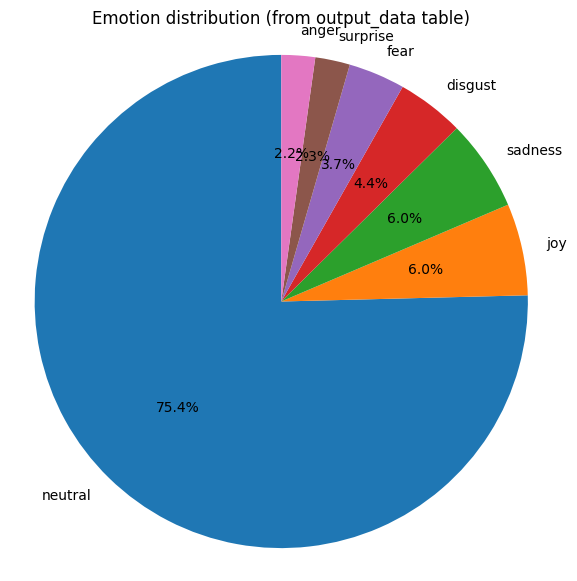

All done. Database file created at: /content/drive/MyDrive/ai_chat_emotion.db
Tables in DB: raw_data, cleaned_data, output_data


In [1]:
# -------------------------
# 0) Install required libs
# -------------------------
!pip install --quiet transformers datasets tqdm sentencepiece sqlalchemy joblib

# -------------------------
# 1) Mount Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# Single DB file in Drive (NO folders created manually)
DB_PATH = "/content/drive/MyDrive/ai_chat_emotion.db"
print("Database path (SQLite file):", DB_PATH)

# -------------------------
# 2) Configurable params
# -------------------------
DATASET_NAME = "lmsys/lmsys-chat-1m"   # change if you want a different dataset
SPLIT = "train"                       # dataset split to use
SAMPLE_PERCENT = "[:1%]"              # sample slice; set "" to use whole split (be careful)
FULL_SPLIT = SPLIT + SAMPLE_PERCENT

# Parallel / performance params
import os
CPU_COUNT = os.cpu_count() or 2
NUM_EXTRACT_WORKERS = min(8, CPU_COUNT)   # for extracting assistant messages
NUM_CLEAN_WORKERS   = min(8, CPU_COUNT)   # for regex cleaning
NUM_PRED_WORKERS    = 2                    # number of worker processes for prediction (tune as needed)
PRED_CHUNK_SIZE     = 128                  # number of texts per chunk submitted to a worker

# Model for emotion classification (changeable)
MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"

# -------------------------
# 3) Imports
# -------------------------
import re
import math
import sqlite3
import pandas as pd
from datasets import load_dataset
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from sqlalchemy import create_engine

# -------------------------
# 4) Helper functions
# -------------------------
# Extract assistant messages from a conversation object (robust to variety of structures)
ROLE_FIELD = "role"
TEXT_FIELDS = ["content", "text", "message", "value"]

def extract_assistant_text_from_conv(conv):
    """Return list of assistant message strings from one conversation object."""
    results = []
    try:
        # normalize to list of messages
        if isinstance(conv, dict):
            # try common keys that hold message lists
            for key in ("conversation", "conversations", "messages", "utterances", "content"):
                if key in conv and isinstance(conv[key], (list, tuple)):
                    conv_list = conv[key]
                    break
            else:
                # maybe it's already a mapping of turn index -> msg
                conv_list = []
                for v in conv.values():
                    if isinstance(v, dict) or isinstance(v, str):
                        conv_list.append(v)
        else:
            conv_list = list(conv)
    except Exception:
        return results

    for msg in conv_list:
        if not isinstance(msg, dict):
            continue
        role = msg.get(ROLE_FIELD) or msg.get("author") or msg.get("speaker") or ""
        if not isinstance(role, str):
            continue
        rl = role.lower()
        if ("assistant" in rl) or ("model" in rl) or ("ai" in rl):
            # find best text field
            text = None
            for tf in TEXT_FIELDS:
                t = msg.get(tf)
                if isinstance(t, str) and t.strip():
                    text = t
                    break
            # sometimes content itself is a dict or list
            if text is None:
                content = msg.get("content")
                if isinstance(content, str):
                    text = content
                elif isinstance(content, dict):
                    # nested forms
                    for k in ("text", "content"):
                        if k in content and isinstance(content[k], str):
                            text = content[k]
                            break
            if text:
                results.append(text)
    return results

def clean_text_regex(text):
    """Regex-based cleaning as requested."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", "", text)                 # remove links
    text = re.sub(r"[\r\n]+", " ", text)                       # newlines -> space
    text = re.sub(r"\[.*?\]", " ", text)                       # remove bracketed blocks
    text = re.sub(r"[^A-Za-z0-9\.,!?\-\'\"():;\s]+", " ", text) # keep basic punctuation
    text = re.sub(r"\s{2,}", " ", text).strip()                # collapse spaces
    return text

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

# -------------------------
# 5) Load dataset and save RAW table
# -------------------------
print("Loading dataset (this may take a bit)...")
ds = load_dataset(DATASET_NAME, split=FULL_SPLIT)  # example: "train[:1%]"
print("Dataset loaded. Columns:", ds.column_names)

# detect conversation-like column
conv_col = None
for cand in ("conversation", "conversations", "messages", "utterances", "content"):
    if cand in ds.column_names:
        conv_col = cand
        break
if conv_col is None:
    # fallback to first column
    conv_col = ds.column_names[0]
print("Using conversation column:", conv_col)

# Extract conversation column (list-like)
conv_list = ds[conv_col]
print("Total conversations to process:", len(conv_list))

# -------------------------
# 6) Parallel extraction of assistant messages
# -------------------------
print(f"Extracting assistant messages in parallel with {NUM_EXTRACT_WORKERS} workers...")
assistant_texts = []  # will preserve original order by mapping results to original indices

# We'll use executor.map to keep order; map returns results in the same order as inputs
with ProcessPoolExecutor(max_workers=NUM_EXTRACT_WORKERS) as ex:
    # ex.map returns an iterator of lists (assistant messages per conversation) in order
    for sublist in tqdm(ex.map(extract_assistant_text_from_conv, conv_list), total=len(conv_list)):
        # extend flattening while maintaining conversation order
        # we store original raw assistant strings as-is (un-cleaned) for raw_data table
        for t in sublist:
            assistant_texts.append(t)

print("Total assistant messages extracted:", len(assistant_texts))
if len(assistant_texts) == 0:
    raise RuntimeError("No assistant messages were extracted. Inspect dataset structure or conv_col selection.")

# Build raw DataFrame and store to DB as raw_data table
raw_df = pd.DataFrame({"assistant_text": assistant_texts})
# Save raw table to SQLite in Drive (DB file will be created automatically)
engine = create_engine(f"sqlite:///{DB_PATH}")
raw_df.to_sql("raw_data", engine, if_exists="replace", index=False)
print("Saved raw_data table to DB:", DB_PATH, "(table: raw_data)  rows:", len(raw_df))

# -------------------------
# 7) Parallel regex cleaning (no sequential apply)
# -------------------------
print(f"Cleaning texts with regex in parallel using {NUM_CLEAN_WORKERS} workers...")
cleaned_texts = []
# Use ProcessPoolExecutor.map to preserve order
with ProcessPoolExecutor(max_workers=NUM_CLEAN_WORKERS) as ex:
    for cleaned in tqdm(ex.map(clean_text_regex, assistant_texts), total=len(assistant_texts)):
        cleaned_texts.append(cleaned)

clean_df = pd.DataFrame({
    "assistant_text": assistant_texts,   # original
    "cleaned_text": cleaned_texts
})
clean_df.to_sql("cleaned_data", engine, if_exists="replace", index=False)
print("Saved cleaned_data table to DB (table: cleaned_data)  rows:", len(clean_df))

# -------------------------
# 8) Fast GPU/CPU Batched Inference (No multiprocessing)
# -------------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

id2label = model.config.id2label if hasattr(model.config, "id2label") else {i: str(i) for i in range(model.config.num_labels)}

texts = clean_df["cleaned_text"].tolist()

BATCH = 64       # increase to 128 if GPU, decrease to 32 if CPU
predictions = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), BATCH)):
        batch = texts[i:i+BATCH]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)
        logits = model(**enc).logits
        idxs = torch.argmax(logits, dim=1).cpu().tolist()
        predictions.extend([id2label[j] for j in idxs])

clean_df["emotion"] = predictions
print("Prediction complete ✔")

# -------------------------
# 9) Save output_data to DB
# -------------------------
clean_df.to_sql("output_data", engine, if_exists="replace", index=False)
print("Saved output_data table ✔ (table: output_data)")
print("Total rows:", len(clean_df))
# -------------------------
# 10) Quick sanity-check queries (read back from DB)
# -------------------------
# Example: read counts of emotions
query = "SELECT emotion, COUNT(*) as cnt FROM output_data GROUP BY emotion ORDER BY cnt DESC"
with engine.connect() as conn:
    stats = pd.read_sql(query, conn)
print("Emotion distribution (top):")
print(stats.head(20))

# -------------------------
# 11) Simple plot (optional)
# -------------------------
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,7))
    vals = stats['cnt'].tolist()
    labs = stats['emotion'].fillna("N/A").tolist()
    plt.pie(vals, labels=labs, autopct="%1.1f%%", startangle=90)
    plt.title("Emotion distribution (from output_data table)")
    plt.axis('equal')
    plt.show()
except Exception as e:
    print("Plotting failed (fine to ignore):", e)

print("All done. Database file created at:", DB_PATH)
print("Tables in DB: raw_data, cleaned_data, output_data")

Emotion Distribution:
emotion
neutral     15130
joy          1208
sadness      1200
disgust       884
fear          744
surprise      457
anger         443
Name: count, dtype: int64


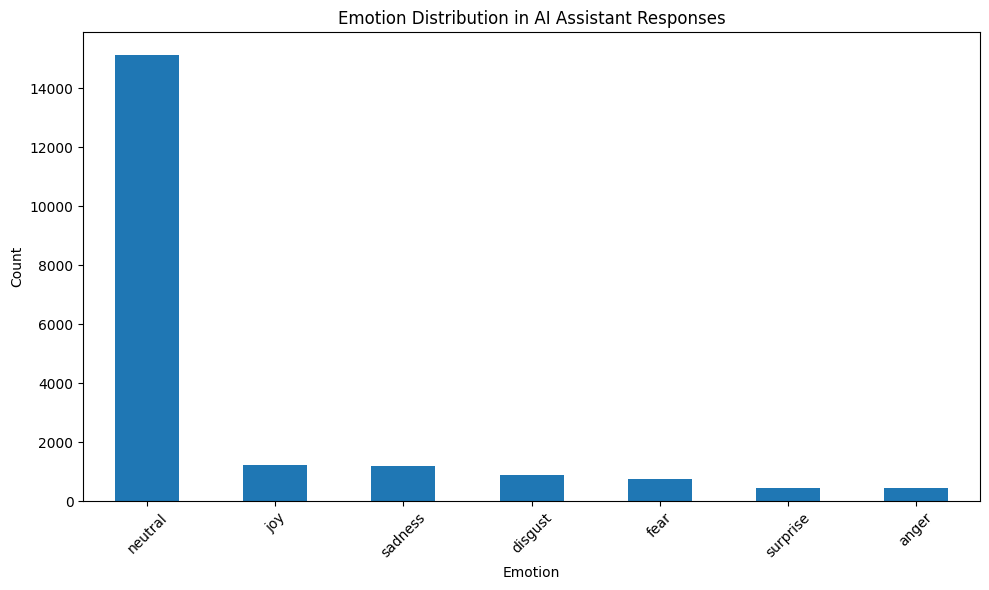

In [3]:
# ===============================
# BAR GRAPH FOR EMOTION ANALYSIS
# ===============================

import pandas as pd
import matplotlib.pyplot as plt

# Load emotion results from DB
df = pd.read_sql("SELECT emotion FROM output_data", engine)

# Count each emotion
emotion_counts = df['emotion'].value_counts()

# Display counts
print("Emotion Distribution:")
print(emotion_counts)

# ======= Plot Bar Graph =======
plt.figure(figsize=(10,6))
emotion_counts.plot(kind='bar')   # (No custom colors since you didn't ask)
plt.title("Emotion Distribution in AI Assistant Responses")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()